In [1]:
# Jade Chongsathapornpong, June 2023
import matplotlib.pyplot as plt
import numpy as np
import fabio
import pyFAI
import pyFAI.azimuthalIntegrator
import pyFAI.calibrant
import pyFAI.gui.jupyter
#%matplotlib nbagg
%matplotlib inline

## Predicted calibration image
We'd like to produce, given an estimated detector geometry and known calibrant powder, a prediction of where diffraction rings will appear. This is the inverse of what pyFAI usually does, and is much easier in principle. 

First, we'll define an azimuthal integrator. Instead of using the geometry reference produced by pyFAI calibration, we'll insert our own. The coordinates are explained in the [documentation](https://www.silx.org/doc/pyFAI/latest/geometry.html) here.

In [123]:
# All distances in m, rotations in radians
center = True # if False, (p1, p2) = (0,0) will be as if a corner of the detector is at the perpendicular sample-detector axis
D = 0.262 # from sample to detector *plane*, orthogonal distance
p1 = 0.202 # point of normal incidence with detector along detector dimension 1
p2 = 0.235 # "" dimension 2
r1 = 0 # rotation axis (w.r.t. sample coordinate system, *not* detector's)
r2 = 0
r3 = 0
l = 1e-10 # wavelength
det = pyFAI.detector_factory("Rayonix SX165")
# print(det.__dict__)

# Shift so that p1 and p2 start at the center of the detector (only works if rotations are zero, i.e. PONI axis aligned to beam)
if center:
    s1 = det.shape[0] * det._pixel1 / 2
    s2 = det.shape[1] * det._pixel2 / 2
    p1 += s1
    p2 += s2

ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=D, poni1=p1, poni2=p2, rot1=r1, rot2=r2, rot3=r3, 
                                                   detector=det, wavelength=l)

Next, we need to define a calibrant compound. This is a bit complicated and I don't quite understand it, so I'll wait for Isabelle/Mauro. For now, we'll assume it's one of the known calibrants.

In [124]:
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = l
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength = l

What the detector will see of the pattern is now visible (this will take a long time for higher resolution detectors, like the Rayonix SX165.)

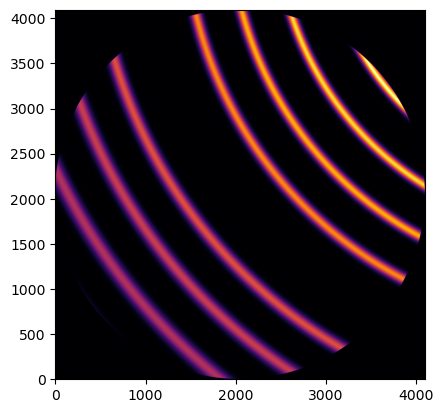

In [125]:
imageLaB6 = LaB6.fake_calibration_image(ai)
# imageAgBh = AgBh.fake_calibration_image(ai)
_ = pyFAI.gui.jupyter.display(imageLaB6)

## Getting $2\theta$ ranges
It turns out that, with a bit of a hack (sorry, Jerome Kieffer) I can extract the $2\theta$ range covered by the pixels in the detector.
It seems that after running `(calibrant instance).fake_calibration_image(azimuthal integrator instance)`, a cached
version of calculated 2-thetas is saved into the azimuthal integrator instance. It's prefixed with an underscore, so it's clearly not intended to be used, probably because it is rarely initialized. The inconvenient thing is that we have to call the costly `fake_calibration_image` each time we calculate the range, but it does work.
Here's some tests to make sure it's what I think it is, and that you can use to calculate the 2-theta range your particular geometry gives. I've verified that translations and rotations affect the calculation as one would expect.

Note: this could be made more explicitly using the `pyfai.geometry.core.tth` function and its array counterpart, but the below code is adequate for our needs.

In [126]:
tth = ai._cached_array['2th_center'].copy()
seen_pixels = np.logical_not(det.mask) # the detector mask is initially a 1 for pixels outside the detector circle. I invert this.
print(tth.shape) # based on the shape, it seems to be one for every pixel
# print("min no mask", np.min(tth) * 180 / np.pi) # this stays near zero if we keep the detector seeing the center
# print("max no mask", np.max(tth) * 180 / np.pi) # if we decrease detector distance, or move away from the center, this increases
print("min with mask", np.min(tth[seen_pixels]) * 180 / np.pi) # cutting out the unseen pixels reduces our 2-theta range.
print("max with mask", np.max(tth[seen_pixels]) * 180 / np.pi)

(4096, 4096)
min with mask 23.716877056860532
max with mask 46.58269201212469


## Superimposing images
Since our goal is informing detector placement, we might want to superimpose two different patterns, for example to see where Sc2O3 diluant peaks will appear. Unfortunately, this isn't built-in to pyFAI.gui. Ideally I'd generate two images with different colormaps and superimpose them, but instead I'll manipulate the images directly into different color channels.

In [27]:
# I'll put LaB6 into the red channel, AgBh into green, and zeros into blue
iLaB6 = np.expand_dims(imageLaB6, 0)
iAgBh = np.expand_dims(imageAgBh, 0)
empty = np.zeros(iLaB6.shape)
colorimage = np.vstack((iLaB6, iAgBh, empty)).transpose((1,2,0))
colorimage.shape # (1043 px x 981 px x 3 channels)

(4096, 4096, 3)

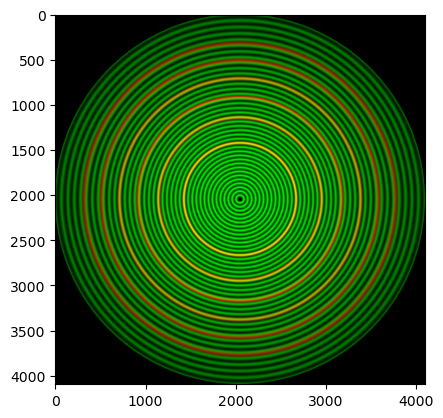

In [28]:
plt.imshow(colorimage)